<a href="https://colab.research.google.com/github/devdogukan/IMDB_sentiment_analysis/blob/main/IMDB_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data handling and exploration with Python.

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/NLP/IMDB Dataset.csv')

### Show first 5 row

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Show last 5 row

In [4]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


### Base dataset info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Value counts

In [7]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


### Checks for missing values in the dataset.

In [8]:
df.isna().sum()

,0
review,0
sentiment,0


### Checks for duplicate values in the dataset.

In [9]:
df.duplicated().sum()

np.int64(418)

# Preparing Text Data: Cleaning, Tokenization, and Normalization (Text preprocessing)

## Clean & Normalization

In [10]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize, pos_tag

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  words = text.split()
  filtered_sentences = ''

  for word in words:
    if word not in stop_words:
      filtered_sentences += f'{word} '

  return filtered_sentences.strip()

In [12]:
def remove_punctuation(text):
  table = str.maketrans('', '', string.punctuation)
  words = text.split()
  filtered_sentences = ''

  for word in words:
    word = word.translate(table)
    filtered_sentences += f'{word} '

  return filtered_sentences.strip()

In [13]:
def normalize_text(text):
  text = text.lower()
  # get rid of urls
  text = re.sub('https?://\S+|www\.\S+', '', text)
  # get rid of non words and extra spaces
  text = re.sub('\\W', ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub(' +', ' ', text)
  text = re.sub('^ ', ' ', text)
  text = re.sub(' $', ' ', text)

  return text

In [14]:
def stemming(text):
  ps = PorterStemmer()
  words = text.split()
  filtered_sentences = ''

  for word in words:
    word = ps.stem(word)
    filtered_sentences += f'{word} '

  return filtered_sentences.strip()

In [15]:
def clean_text(text):
  text = text.lower()
  text = text.replace(',',' , ')
  text = text.replace('.',' . ')
  text = text.replace('/',' / ')
  text = text.replace('@',' @ ')
  text = text.replace('#',' # ')
  text = text.replace('?',' ? ')
  text = normalize_text(text)
  text = remove_punctuation(text)
  text = remove_stopwords(text)
  text = stemming(text)

  return text

In [16]:
df['review'] = df['review'].apply(clean_text)

### Dataset Splitting and Labels Encoding

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [18]:
X = df['review']
y = df['sentiment']

encoder = OneHotEncoder()
y = encoder.fit_transform(np.asarray(y).reshape(-1, 1)).toarray()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

### Tokenization and Padding

In [20]:
# important libraries for deep learning
import tensorflow as tf
from tensorflow import keras

# for tokenizing texts
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore

# for text padding and truncating
from tensorflow.keras.utils import pad_sequences # type: ignore

Properties

In [21]:
vocab_size = 10000
max_length = 50

trunch_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'

Define tokenizer and fit on texts

In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

Tokenize and pad texts

In [23]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunch_type)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunch_type)

### Model Building and Training

Model Building

In [24]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

In [30]:
def build_model():
    model = Sequential()

    model.add(Embedding(vocab_size, 64))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout regularization

    model.add(LSTM(32, return_sequences=True))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))  # Add dropout regularization

    model.add(LSTM(32))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))  # Add dropout regularization

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Apply early stopping

    return model, early_stopping

In [31]:
model, early_stopping = build_model()

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
batch_size = 250
history = model.fit(X_train,y_train,epochs=15,batch_size=batch_size,validation_split=.1,callbacks=[early_stopping])

Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6771 - loss: 0.5740 - val_accuracy: 0.8242 - val_loss: 0.3927
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8625 - loss: 0.3246 - val_accuracy: 0.8273 - val_loss: 0.4181
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8910 - loss: 0.2775 - val_accuracy: 0.8255 - val_loss: 0.3963
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9169 - loss: 0.2248 - val_accuracy: 0.8167 - val_loss: 0.4831


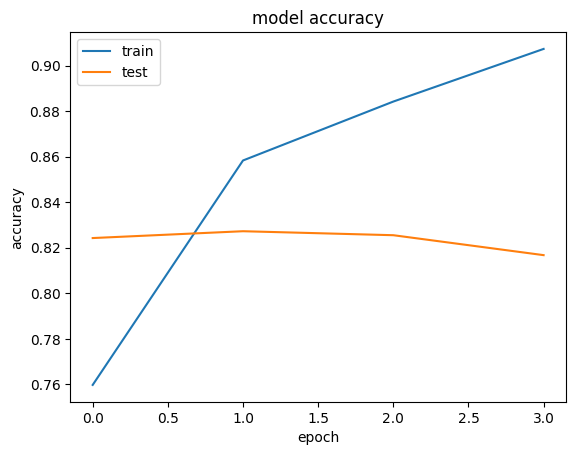

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Evaluation

In [35]:
score = model.evaluate(np.asarray(X_test),np.asarray(y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8272 - loss: 0.4468


In [36]:
print(f"on test split\nLoss: {round(score[0],4)}, accuracy: {round(score[1],2)*100}%")

on test split
Loss: 0.4693, accuracy: 82.0%


In [37]:
pred = model.predict(X_test)
pred = encoder.inverse_transform(pred)
test = encoder.inverse_transform(y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


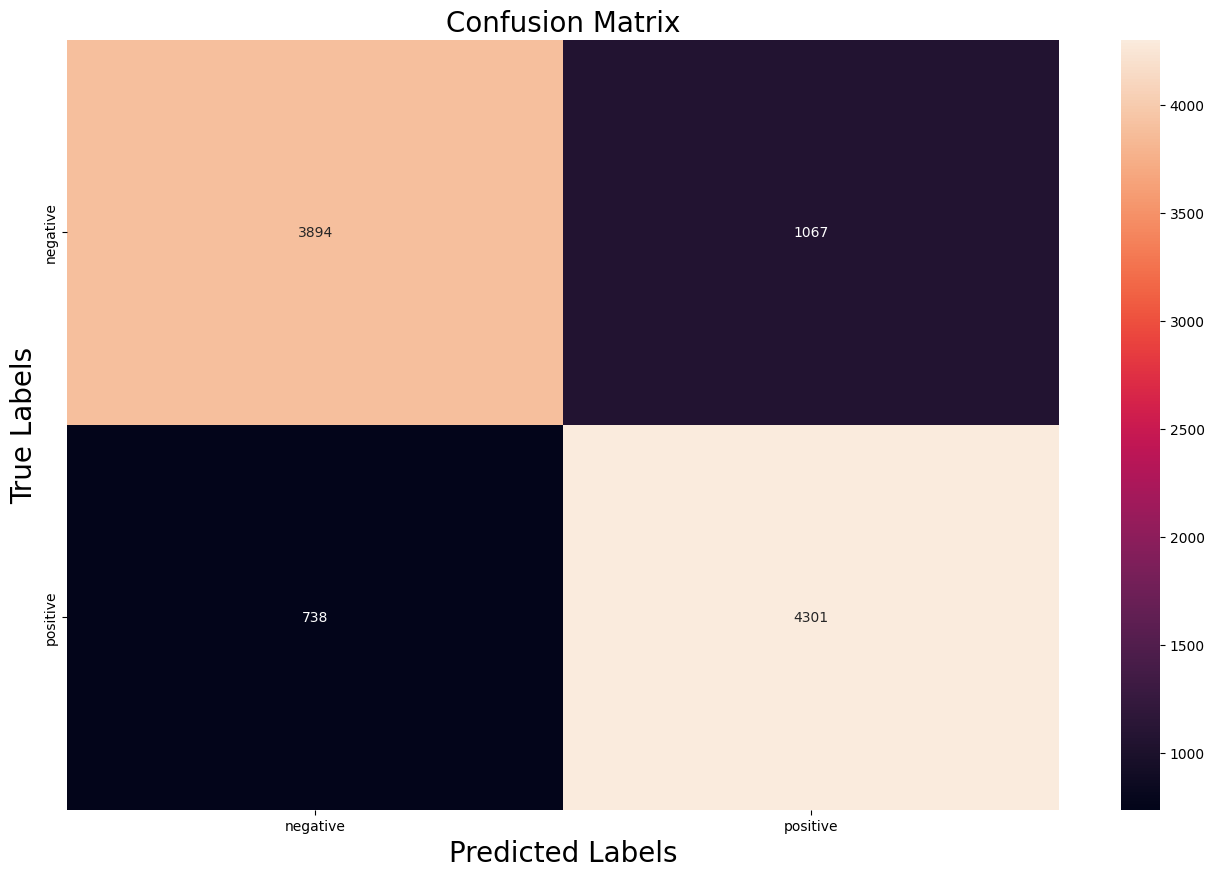

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


matrix = confusion_matrix(test, pred, labels=["negative","positive"])
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(["negative","positive"], size=10)
ax.yaxis.set_ticklabels(["negative","positive"], size=10)
plt.savefig('confusio_matrix.png')

In [40]:
from sklearn.metrics import classification_report

report = classification_report(test, pred)

print(report)

              precision    recall  f1-score   support

    negative       0.84      0.78      0.81      4961
    positive       0.80      0.85      0.83      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [41]:
model.save('/content/drive/MyDrive/NLP/checkpoint_01.h5')